# Initialization and Preprocessing

## Depndencies

In [1]:
# handle imports
import os
import tensorflow as tf
from PIL import Image
import random
import pathlib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, LassoCV, RidgeCV

from sklearn.model_selection import GridSearchCV, train_test_split

# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report

# Plotter
import matplotlib.pyplot as plt

In [2]:
current_path = os.getcwd()
dataset_path = current_path + '\data'
dataset_path

'c:\\Users\\a1351\\OneDrive - sjsu.edu\\MSEE\\EE257 - Machine Learning\\Project\\data'

In [3]:
os.curdir

'.'

## Importing Data - Note this will work differently for Nick!

In [4]:
# Load dataset and split

data_dir = pathlib.Path('./data')
batch_size = 32

def describe_img(filepath):
    rand_img = random.choice(list(filepath.glob('./*.jpg')))
    width, height = Image.open(str(rand_img)).size
    return width, height

def random_img(filepath):
    return  random.choice(list(filepath.glob('./*.jpg')))

img_width, img_height = describe_img(data_dir)

ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed = 123,
    color_mode="grayscale",
    image_size = (img_height , img_width),
    batch_size = batch_size
)

print('Image Widths:', img_width)
print('Image heights:', img_height)

Found 597 files belonging to 4 classes.
Image Widths: 250
Image heights: 250


In [5]:
class_names = ds.class_names
for name in class_names:
    print(name)

Cofield
Depuy
Tornier
Zimmer


[83, 294, 71, 149]


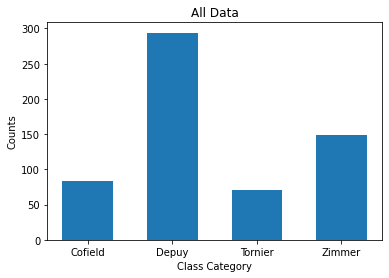

In [6]:
class_counts = [0,0,0,0]
i=0

for all_img, all_labels in ds:
    for cat in all_labels:
        class_counts[cat]+=1

print(class_counts)
distribution_data = dict(zip(class_names,class_counts))
plt.bar(list(distribution_data.keys()),distribution_data.values(),width =0.6)
plt.title('All Data')
plt.xlabel('Class Category')
plt.ylabel('Counts')
plt.show()


Above is a histogram representating our data.  There are 4 classes based on the machines that received the data:  Cofield, Depuy, Tornier, and Zimmer.  There are 83 Cofield samples, 294 Depuy samples, 71 Tornier samples, and 149 Zimmer samples.  This is not a balanced dataset.

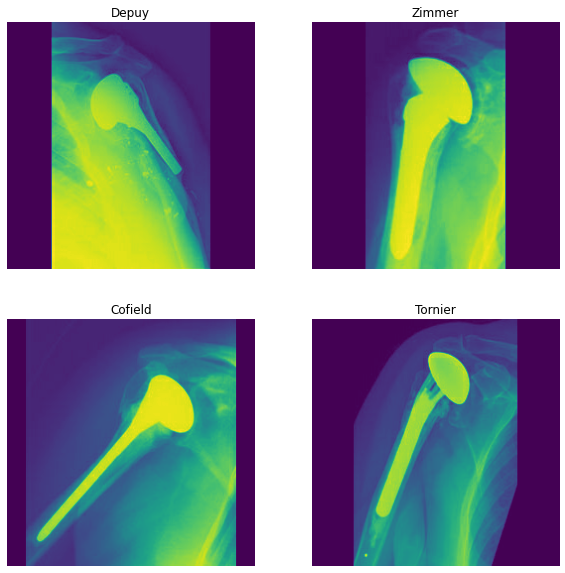

In [7]:
unique = []
i=0
plt.figure(figsize=(10, 10))
for images, labels in ds.take(1):
    for item in range(len(labels)):
        if labels[item] in unique:
            continue
        else:
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(images[item].numpy().astype("uint8"))
            plt.title(class_names[labels[item]])
            plt.axis("off")

            i+=1
            unique.append(labels[item])
        
    break # run only once through a batch

Above are some visual examples of some of the X-rays that we are classifying.  I'm guessing the resolution/brightnesses of the machines are different from one another.

Split the dataset batches into 570x(number of pixels) arrays

In [8]:
def dataset_to_2D(dataset):
    x = []
    y = []
    for img_batch, label_batch in dataset:
        # flatten images since model fit() needs 2D input
        for img in img_batch:
            x.append(img.flatten())
        for label in label_batch:
            y.append(label)

    # Convert from type 'list' to type 'ndarray'
    x = np.asarray(x)

    return x, y

# Create the full x and y sets.        
x, y = dataset_to_2D(ds.as_numpy_iterator())

print(np.shape(x))
print(np.shape(y))

# Use train_test_split to create stratified splits of the dataset (ensure the training is balanced).
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y)

(597, 62500)
(597,)


# Baseline Models

## Support Vector Classifier

In [9]:
base_svm = SVC()
base_svm.fit(x_train,y_train)
y_pred_base_svm = base_svm.predict(x_test)

In [10]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_base_svm))
print("--------------------------")
print(classification_report(y_test, y_pred_base_svm, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 2 17  0  2]
 [ 0 73  0  1]
 [ 0 14  0  4]
 [ 0 31  0  6]]
--------------------------
              precision    recall  f1-score   support

     Cofield       1.00      0.10      0.17        21
       Depuy       0.54      0.99      0.70        74
     Tornier       0.00      0.00      0.00        18
      Zimmer       0.46      0.16      0.24        37

    accuracy                           0.54       150
   macro avg       0.50      0.31      0.28       150
weighted avg       0.52      0.54      0.43       150



In [11]:
svm_lin = SVC(kernel='linear')
svm_lin.fit(x_train,y_train)
y_pred_svm_lin = svm_lin.predict(x_test)

In [12]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_svm_lin))
print("--------------------------")
print(classification_report(y_test, y_pred_svm_lin, target_names=['Cofield', 'Depuy', 'Tornier', 'Zimmer']))

Confusion Matrix
[[10  7  0  4]
 [ 3 55  6 10]
 [ 0  9  4  5]
 [ 6 17  4 10]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.53      0.48      0.50        21
       Depuy       0.62      0.74      0.68        74
     Tornier       0.29      0.22      0.25        18
      Zimmer       0.34      0.27      0.30        37

    accuracy                           0.53       150
   macro avg       0.45      0.43      0.43       150
weighted avg       0.50      0.53      0.51       150



## Logistic Regression

In [13]:
base_log = LogisticRegression(max_iter=10000)
base_log.fit(x_train,y_train)
y_pred_base_log = base_log.predict(x_test)

In [14]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_base_log))
print("--------------------------")
print(classification_report(y_test, y_pred_base_log, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 7  9  0  5]
 [ 2 51  7 14]
 [ 1  8  4  5]
 [ 6 17  5  9]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.44      0.33      0.38        21
       Depuy       0.60      0.69      0.64        74
     Tornier       0.25      0.22      0.24        18
      Zimmer       0.27      0.24      0.26        37

    accuracy                           0.47       150
   macro avg       0.39      0.37      0.38       150
weighted avg       0.45      0.47      0.46       150



## Random Forest Classifier

In [15]:
base_rfc = RandomForestClassifier()
base_rfc.fit(x_train,y_train)
y_pred_base_rfc = base_rfc.predict(x_test)

In [16]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_base_rfc))
print("--------------------------")
print(classification_report(y_test, y_pred_base_rfc, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 8 10  1  2]
 [ 1 65  1  7]
 [ 2 12  1  3]
 [ 1 24  1 11]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.67      0.38      0.48        21
       Depuy       0.59      0.88      0.70        74
     Tornier       0.25      0.06      0.09        18
      Zimmer       0.48      0.30      0.37        37

    accuracy                           0.57       150
   macro avg       0.50      0.40      0.41       150
weighted avg       0.53      0.57      0.52       150



## Decision Tree Classifier

In [17]:
base_dtc = DecisionTreeClassifier()
base_dtc.fit(x_train,y_train)
y_pred_base_dtc = base_dtc.predict(x_test)

In [18]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_base_dtc))
print("--------------------------")
print(classification_report(y_test, y_pred_base_dtc, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 7 10  0  4]
 [ 4 49 10 11]
 [ 3  9  2  4]
 [ 1 13 13 10]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.47      0.33      0.39        21
       Depuy       0.60      0.66      0.63        74
     Tornier       0.08      0.11      0.09        18
      Zimmer       0.34      0.27      0.30        37

    accuracy                           0.45       150
   macro avg       0.37      0.34      0.35       150
weighted avg       0.46      0.45      0.45       150



## K-Nearest Neighbors Classifier

In [19]:
base_knn = KNeighborsClassifier()
base_knn.fit(x_train,y_train)
y_pred_base_knn = base_knn.predict(x_test)

In [20]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_base_knn))
print("--------------------------")
print(classification_report(y_test, y_pred_base_knn, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 3 12  0  6]
 [ 4 60  3  7]
 [ 1 11  1  5]
 [ 0 28  2  7]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.38      0.14      0.21        21
       Depuy       0.54      0.81      0.65        74
     Tornier       0.17      0.06      0.08        18
      Zimmer       0.28      0.19      0.23        37

    accuracy                           0.47       150
   macro avg       0.34      0.30      0.29       150
weighted avg       0.41      0.47      0.41       150



Note:  The accuracies of the baseline models are fairly low.  I could try some L1/L2 optimization here, but this won't fix the problem with the training accuracies being low.  Perhaps some hyperparameter tuning is in order here.

# Optimization

## Regularization

In [21]:
## L1 Regularization

lasso = Lasso(max_iter=10000)
lasso.fit(x_train,y_train)

l1_select = SelectFromModel(lasso).fit(x_train, y_train)
x_train_l1 = l1_select.transform(x_train)
x_test_l1 = l1_select.transform(x_test)

In [22]:
## L2 Regularization

ridge = Ridge(max_iter=10000)
ridge.fit(x_train,y_train)

l2_select = SelectFromModel(ridge).fit(x_train,y_train)
x_train_l2 = l2_select.transform(x_train)
x_test_l2 = l2_select.transform(x_test)

c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.02135e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.02135e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


## Hyper-parameter Tuning

In [23]:
### Step 1 is to optimize the paramaters.  This function takes the name of the function

def optimize_scores(model):

    score='f1'
    print('Best scores for %s:' % model['name'])
    print(model['params'])

    # Optimize for Accuracy

    print('# Tuning hyper-parameters for %s' % score)
    print('')

    # Run GridSeasrchCV on the model.
    clf = GridSearchCV(model['function'], model['params'], scoring=score, cv=10, n_jobs=-1)
    clf.fit(x_train, y_train)

    print('Best parameters set found on development set:')
    print('')
    print(clf.best_params_)
    print('')

    # Testing on the development set.
    print('Grid scores on development set:')
    print('')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print('%0.3f (+/-%0.03f) for %r' % (mean, std*2, params))
    print('')

    # Classification report on the test set.
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

    # Getting the best vals based on accuracy
    bestvals = clf.best_params_
    # Return the name, function, and best parameters found for the model.
    optimized_model = {'name': model['name'], 'function': model['function'], 'params': bestvals}
    return optimized_model

# L1 Regularized Baseline Models

## Support Vector Classifier

In [24]:
l1_svm = SVC()
l1_svm.fit(x_train_l1,y_train)
y_pred_l1_svm = l1_svm.predict(x_test_l1)

In [25]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_l1_svm))
print("--------------------------")
print(classification_report(y_test, y_pred_l1_svm, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 3 16  0  2]
 [ 0 71  0  3]
 [ 0 13  0  5]
 [ 0 31  0  6]]
--------------------------
              precision    recall  f1-score   support

     Cofield       1.00      0.14      0.25        21
       Depuy       0.54      0.96      0.69        74
     Tornier       0.00      0.00      0.00        18
      Zimmer       0.38      0.16      0.23        37

    accuracy                           0.53       150
   macro avg       0.48      0.32      0.29       150
weighted avg       0.50      0.53      0.43       150



In [26]:
svm_lin_l1 = SVC(kernel='linear')
svm_lin_l1.fit(x_train_l1,y_train)
y_pred_svm_lin_l1 = svm_lin_l1.predict(x_test_l1)

In [27]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_svm_lin_l1))
print("--------------------------")
print(classification_report(y_test, y_pred_svm_lin_l1, target_names=['Cofield', 'Depuy', 'Tornier', 'Zimmer']))

Confusion Matrix
[[ 7  8  2  4]
 [ 6 45  8 15]
 [ 2  6  5  5]
 [ 6 21  2  8]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.33      0.33      0.33        21
       Depuy       0.56      0.61      0.58        74
     Tornier       0.29      0.28      0.29        18
      Zimmer       0.25      0.22      0.23        37

    accuracy                           0.43       150
   macro avg       0.36      0.36      0.36       150
weighted avg       0.42      0.43      0.43       150



## Logistic Regression

In [28]:
l1_log = LogisticRegression(max_iter=10000)
l1_log.fit(x_train_l1,y_train)
y_pred_l1_log = l1_log.predict(x_test_l1)

In [29]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_l1_log))
print("--------------------------")
print(classification_report(y_test, y_pred_l1_log, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 7  7  3  4]
 [ 6 42  9 17]
 [ 2  4  4  8]
 [ 3 16  6 12]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.39      0.33      0.36        21
       Depuy       0.61      0.57      0.59        74
     Tornier       0.18      0.22      0.20        18
      Zimmer       0.29      0.32      0.31        37

    accuracy                           0.43       150
   macro avg       0.37      0.36      0.36       150
weighted avg       0.45      0.43      0.44       150



## Random Forest Classifier

In [30]:
l1_rfc = RandomForestClassifier()
l1_rfc.fit(x_train_l1,y_train)
y_pred_l1_rfc = l1_rfc.predict(x_test_l1)

In [31]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_l1_rfc))
print("--------------------------")
print(classification_report(y_test, y_pred_l1_rfc, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 5 13  2  1]
 [ 0 70  0  4]
 [ 0 13  1  4]
 [ 1 27  0  9]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.83      0.24      0.37        21
       Depuy       0.57      0.95      0.71        74
     Tornier       0.33      0.06      0.10        18
      Zimmer       0.50      0.24      0.33        37

    accuracy                           0.57       150
   macro avg       0.56      0.37      0.38       150
weighted avg       0.56      0.57      0.49       150



## Decision Tree Classifier

In [32]:
l1_dtc = DecisionTreeClassifier()
l1_dtc.fit(x_train_l1,y_train)
y_pred_l1_dtc = l1_dtc.predict(x_test_l1)

In [33]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_l1_dtc))
print("--------------------------")
print(classification_report(y_test, y_pred_l1_dtc, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 6  8  3  4]
 [ 5 38  9 22]
 [ 2 12  2  2]
 [ 1 16 10 10]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.43      0.29      0.34        21
       Depuy       0.51      0.51      0.51        74
     Tornier       0.08      0.11      0.10        18
      Zimmer       0.26      0.27      0.27        37

    accuracy                           0.37       150
   macro avg       0.32      0.30      0.30       150
weighted avg       0.39      0.37      0.38       150



## K-Nearest Neighbors Classifier

In [34]:
l1_knn = KNeighborsClassifier()
l1_knn.fit(x_train_l1,y_train)
y_pred_l1_knn = l1_knn.predict(x_test_l1)

In [35]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_l1_knn))
print("--------------------------")
print(classification_report(y_test, y_pred_l1_knn, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 3 14  0  4]
 [ 4 61  2  7]
 [ 2 12  1  3]
 [ 1 29  0  7]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.30      0.14      0.19        21
       Depuy       0.53      0.82      0.64        74
     Tornier       0.33      0.06      0.10        18
      Zimmer       0.33      0.19      0.24        37

    accuracy                           0.48       150
   macro avg       0.37      0.30      0.29       150
weighted avg       0.42      0.48      0.41       150



# Optimized Models

## SVM

In [36]:
# Generate the optimized SVM hyperparameters.

# A note on the SVC module:  The penalty is controlled by the C parameter and it adjusts the L2 regularization.

svm = {'name': 'SVM', 'function': SVC(), 'params': {'random_state': [42],
       'kernel': ['rbf', 'linear', 'poly'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [0.01, 0.1, 1, 10]}}
optimized_svm = optimize_scores(svm)
optimized_svm

Best scores for SVM:
{'random_state': [42], 'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.01, 0.001, 0.0001], 'C': [0.01, 0.1, 1, 10]}
# Tuning hyper-parameters for f1



c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters set found on development set:

{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 42}

Grid scores on development set:

nan (+/-nan) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'poly', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'poly', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear', 'random_state': 42}
nan (+/-nan) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'poly', 'random_state': 42}
nan (+/-nan) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 42}
nan (+/-nan) for {'C': 0.

c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'name': 'SVM',
 'function': SVC(),
 'params': {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 42}}

## Random Forest Classifier

In [37]:
# Generate the optimized Random Forest Classifier hyperparameters
rfc = {'name': 'RFC', 'function': RandomForestClassifier(), 'params': {'n_estimators' : [1, 100, 1000],
       'criterion' : ['gini', 'entropy']}}
optimized_rfc = optimize_scores(rfc)
optimized_rfc

Best scores for RFC:
{'n_estimators': [1, 100, 1000], 'criterion': ['gini', 'entropy']}
# Tuning hyper-parameters for f1



c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Best parameters set found on development set:

{'criterion': 'gini', 'n_estimators': 1}

Grid scores on development set:

nan (+/-nan) for {'criterion': 'gini', 'n_estimators': 1}
nan (+/-nan) for {'criterion': 'gini', 'n_estimators': 100}
nan (+/-nan) for {'criterion': 'gini', 'n_estimators': 1000}
nan (+/-nan) for {'criterion': 'entropy', 'n_estimators': 1}
nan (+/-nan) for {'criterion': 'entropy', 'n_estimators': 100}
nan (+/-nan) for {'criterion': 'entropy', 'n_estimators': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.38      0.43      0.40        21
           1       0.54      0.54      0.54        74
           2       0.17      0.11      0.13        18
           3       0.25      0.27      0.26        37

    accuracy                           0.41       150
   macro avg       0.33      0.34      0.33     

{'name': 'RFC',
 'function': RandomForestClassifier(),
 'params': {'criterion': 'gini', 'n_estimators': 1}}

## Decision Tree Classifier

In [38]:
# Generate the optimized Decision Tree Classifier hyperparameters
dtc = {'name': 'DTC', 'function': DecisionTreeClassifier(), 'params': {'criterion' : ['gini', 'entropy'],
       'splitter' : ['best', 'random']}}
optimized_dtc = optimize_scores(dtc)
optimized_dtc

Best scores for DTC:
{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}
# Tuning hyper-parameters for f1



c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best parameters set found on development set:

{'criterion': 'gini', 'splitter': 'best'}

Grid scores on development set:

nan (+/-nan) for {'criterion': 'gini', 'splitter': 'best'}
nan (+/-nan) for {'criterion': 'gini', 'splitter': 'random'}
nan (+/-nan) for {'criterion': 'entropy', 'splitter': 'best'}
nan (+/-nan) for {'criterion': 'entropy', 'splitter': 'random'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.25      0.24      0.24        21
           1       0.62      0.61      0.62        74
           2       0.26      0.33      0.29        18
           3       0.31      0.30      0.31        37

    accuracy                           0.45       150
   macro avg       0.36      0.37      0.36       150
weighted avg       0.45      0.45      0.45       150




{'name': 'DTC',
 'function': DecisionTreeClassifier(),
 'params': {'criterion': 'gini', 'splitter': 'best'}}

## Logistic Regression

In [39]:
## Logistic regression hits the resource limiter.

log = {'name': 'LOG', 'function': LogisticRegression(n_jobs=-1, max_iter=10000), 'params': {'penalty' : ['l2', 'elasticnet', 'none'], 'C' : [0.01, 0.1, 1]}}
optimized_log = optimize_scores(log)
optimized_log

Best scores for LOG:
{'penalty': ['l2', 'elasticnet', 'none'], 'C': [0.01, 0.1, 1]}
# Tuning hyper-parameters for f1



c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\linear_mo

Best parameters set found on development set:

{'C': 0.01, 'penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'C': 0.01, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.01, 'penalty': 'elasticnet'}
nan (+/-nan) for {'C': 0.01, 'penalty': 'none'}
nan (+/-nan) for {'C': 0.1, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'penalty': 'elasticnet'}
nan (+/-nan) for {'C': 0.1, 'penalty': 'none'}
nan (+/-nan) for {'C': 1, 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'penalty': 'elasticnet'}
nan (+/-nan) for {'C': 1, 'penalty': 'none'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.44      0.33      0.38        21
           1       0.61      0.69      0.65        74
           2       0.25      0.22      0.24        18
           3       0.26      0.24      0.25        37

    accuracy                           0.47      

{'name': 'LOG',
 'function': LogisticRegression(max_iter=10000, n_jobs=-1),
 'params': {'C': 0.01, 'penalty': 'l2'}}

# Running the final models

## Support Vector Classifier

In [40]:
final_svm = SVC()
final_svm.set_params(**optimized_svm['params'])
final_svm.fit(x_train,y_train)
y_pred_final_svm = final_svm.predict(x_test)

In [41]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_svm))
print("--------------------------")
print(classification_report(y_test, y_pred_final_svm, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 0 21  0  0]
 [ 0 74  0  0]
 [ 0 18  0  0]
 [ 0 37  0  0]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.00      0.00      0.00        21
       Depuy       0.49      1.00      0.66        74
     Tornier       0.00      0.00      0.00        18
      Zimmer       0.00      0.00      0.00        37

    accuracy                           0.49       150
   macro avg       0.12      0.25      0.17       150
weighted avg       0.24      0.49      0.33       150



In [42]:
final_svm_l1 = SVC()
final_svm_l1.set_params(**optimized_svm['params'])
final_svm_l1.fit(x_train_l1,y_train)
y_pred_final_svm_l1 = final_svm_l1.predict(x_test_l1)

In [43]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_svm_l1))
print("--------------------------")
print(classification_report(y_test, y_pred_final_svm_l1, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 0 21  0  0]
 [ 0 74  0  0]
 [ 0 18  0  0]
 [ 0 37  0  0]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.00      0.00      0.00        21
       Depuy       0.49      1.00      0.66        74
     Tornier       0.00      0.00      0.00        18
      Zimmer       0.00      0.00      0.00        37

    accuracy                           0.49       150
   macro avg       0.12      0.25      0.17       150
weighted avg       0.24      0.49      0.33       150



## Random Forest Classifier

In [44]:
final_rfc = RandomForestClassifier()
final_rfc.set_params(**optimized_rfc['params'])
final_rfc.fit(x_train,y_train)
y_pred_final_rfc = final_rfc.predict(x_test)

In [45]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_rfc))
print("--------------------------")
print(classification_report(y_test, y_pred_final_rfc, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[10  4  4  3]
 [10 43  7 14]
 [ 5  6  2  5]
 [ 1 11  9 16]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.38      0.48      0.43        21
       Depuy       0.67      0.58      0.62        74
     Tornier       0.09      0.11      0.10        18
      Zimmer       0.42      0.43      0.43        37

    accuracy                           0.47       150
   macro avg       0.39      0.40      0.39       150
weighted avg       0.50      0.47      0.48       150



In [46]:
final_rfc_l1 = RandomForestClassifier()
final_rfc_l1.set_params(**optimized_rfc['params'])
final_rfc_l1.fit(x_train_l1,y_train)
y_pred_final_rfc_l1 = final_rfc_l1.predict(x_test_l1)

In [47]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_rfc_l1))
print("--------------------------")
print(classification_report(y_test, y_pred_final_rfc_l1, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 2 12  6  1]
 [11 39 10 14]
 [ 4  6  4  4]
 [ 5 17  5 10]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.09      0.10      0.09        21
       Depuy       0.53      0.53      0.53        74
     Tornier       0.16      0.22      0.19        18
      Zimmer       0.34      0.27      0.30        37

    accuracy                           0.37       150
   macro avg       0.28      0.28      0.28       150
weighted avg       0.38      0.37      0.37       150



## Decision Tree Classifier

In [48]:
final_dtc = DecisionTreeClassifier()
final_dtc.set_params(**optimized_dtc['params'])
final_dtc.fit(x_train,y_train)
y_pred_final_dtc = final_dtc.predict(x_test)

In [49]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_dtc))
print("--------------------------")
print(classification_report(y_test, y_pred_final_dtc, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 5  7  3  6]
 [ 4 51 13  6]
 [ 3  7  5  3]
 [ 4 13  3 17]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.31      0.24      0.27        21
       Depuy       0.65      0.69      0.67        74
     Tornier       0.21      0.28      0.24        18
      Zimmer       0.53      0.46      0.49        37

    accuracy                           0.52       150
   macro avg       0.43      0.42      0.42       150
weighted avg       0.52      0.52      0.52       150



In [50]:
final_dtc_l1 = DecisionTreeClassifier()
final_dtc_l1.set_params(**optimized_dtc['params'])
final_dtc_l1.fit(x_train_l1,y_train)
y_pred_final_dtc_l1 = final_dtc_l1.predict(x_test_l1)

In [51]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_dtc_l1))
print("--------------------------")
print(classification_report(y_test, y_pred_final_dtc_l1, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 7  7  4  3]
 [ 7 34  8 25]
 [ 2 11  2  3]
 [ 3 18  5 11]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.37      0.33      0.35        21
       Depuy       0.49      0.46      0.47        74
     Tornier       0.11      0.11      0.11        18
      Zimmer       0.26      0.30      0.28        37

    accuracy                           0.36       150
   macro avg       0.31      0.30      0.30       150
weighted avg       0.37      0.36      0.36       150



## Logistic Regression

In [52]:
final_log = LogisticRegression()
final_log.set_params(**optimized_log['params'])
final_log.fit(x_train,y_train)
y_pred_final_log = final_log.predict(x_test)

c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_log))
print("--------------------------")
print(classification_report(y_test, y_pred_final_log, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 8  6  1  6]
 [ 4 51  6 13]
 [ 1  6  7  4]
 [ 6 14  5 12]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.42      0.38      0.40        21
       Depuy       0.66      0.69      0.68        74
     Tornier       0.37      0.39      0.38        18
      Zimmer       0.34      0.32      0.33        37

    accuracy                           0.52       150
   macro avg       0.45      0.45      0.45       150
weighted avg       0.51      0.52      0.52       150



In [54]:
final_log_l1 = LogisticRegression()
final_log_l1.set_params(**optimized_log['params'])
final_log_l1.fit(x_train_l1,y_train)
y_pred_final_log_l1 = final_log_l1.predict(x_test_l1)

c:\ProgramData\Anaconda3\envs\birdclef2022\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_final_log_l1))
print("--------------------------")
print(classification_report(y_test, y_pred_final_log_l1, target_names=['Cofield' , 'Depuy' , 'Tornier' , 'Zimmer'], zero_division=0))

Confusion Matrix
[[ 7  7  2  5]
 [ 3 46  7 18]
 [ 3  5  5  5]
 [ 5 16  5 11]]
--------------------------
              precision    recall  f1-score   support

     Cofield       0.39      0.33      0.36        21
       Depuy       0.62      0.62      0.62        74
     Tornier       0.26      0.28      0.27        18
      Zimmer       0.28      0.30      0.29        37

    accuracy                           0.46       150
   macro avg       0.39      0.38      0.39       150
weighted avg       0.46      0.46      0.46       150

